In [89]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

In [90]:
# Declare the credentials
client_id = 'a6ef729f004748cabd5a6ba6d39bcdee'
client_secret = '009f38f47b4b4a01b98e70380bbe233d'
redirect_uri='http://localhost:7777/callback'
username = '383yg3vhnzhume0s2ug7p5y26'
#"383yg3vhnzhume0s2ug7p5y26' is Nur's account 

In [91]:
# Authorization flow
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [92]:
# Getting features for each song
def fetch_audio_features(sp, df):
    playlist = df[['track_id','track_name']] 
    index = 0
    audio_features = []
    
    # Make the API request
    while index < playlist.shape[0]:
        audio_features += sp.audio_features(playlist.iloc[index:index + 70, 0])
        index += 70
    
    # Create an empty list to feed in different charactieritcs of the tracks
    features_list = []
    #Create keys-values of empty lists inside nested dictionary for album
    for features in audio_features:
        features_list.append([features['danceability'],
                              features['acousticness'],
                              features['energy'], 
                              features['tempo'],
                              features['instrumentalness'], 
                              features['loudness'],
                              features['liveness'],
                              features['duration_ms'],
                              features['key'],
                              features['valence'],
                              features['speechiness'],
                              features['mode']
                             ])
    
    df_audio_features = pd.DataFrame(features_list, columns=['danceability', 'acousticness', 'energy','tempo', 
                                                             'instrumentalness', 'loudness', 'liveness','duration_ms', 'key',
                                                             'valence', 'speechiness', 'mode'])
    
    # Create the final df, using the 'track_id' as index for future reference
    df_playlist_audio_features = pd.concat([playlist, df_audio_features], axis=1)
    df_playlist_audio_features.set_index('track_name', inplace=True, drop=True)
    return df_playlist_audio_features

In [93]:
# # Getting playlist IDs from each of Spotify's playlists
playlists = sp.user_playlists('spotify')
spotify_playlist_ids = []
while playlists:
    for i, playlist in enumerate(playlists['items']):
        spotify_playlist_ids.append(playlist['uri'][-22:])
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None
spotify_playlist_ids[:5]
#change 5 to 20

['37i9dQZF1DXcBWIGoYBM5M',
 '37i9dQZF1DX0XUsuxWHRQd',
 '37i9dQZF1DX1lVhptIYRda',
 '37i9dQZF1DX10zKzsJ2jva',
 '37i9dQZF1DX4JAvHpjipBk']

In [94]:
len(spotify_playlist_ids)

1112

In [95]:
#Getting tracks from Spotify playlists
# Creating a function to get the first 50 tracks IDs from a playlist
#def getTrackIDs(playlist_id):
 #   playlist = sp.user_playlist('spotify', playlist_id)
 #   for item in playlist['tracks']['items'][:50]:
 #       track = item['track']
 #       ids.append(track['id'])
 #   return


In [96]:
# Creating a function get features of each track from track id
def getTrackFeatures(track_id):
  meta = sp.track(track_id)
  features = sp.audio_features(track_id)

  # meta
  track_id = track_id
  name = meta['name']
  album = meta['album']['name']
  artist = meta['album']['artists'][0]['name']
  release_date = meta['album']['release_date']
  length = meta['duration_ms']
  popularity = meta['popularity']

  # features
  acousticness = features[0]['acousticness']
  danceability = features[0]['danceability']
  energy = features[0]['energy']
  instrumentalness = features[0]['instrumentalness']
  liveness = features[0]['liveness']
  loudness = features[0]['loudness']
  speechiness = features[0]['speechiness']
  tempo = features[0]['tempo']
  time_signature = features[0]['time_signature']

  track = [track_id, name, album, artist, release_date, length, popularity, danceability, acousticness, energy, instrumentalness, liveness, loudness, speechiness, tempo, time_signature]
  return track

In [97]:
#Getting tracks from Spotify playlists
# Creating a function to get the first 50 tracks IDs from a playlist
def getTrackIDs(playlist_id):
    try:
        playlist = sp.playlist(playlist_id)
        for item in playlist['tracks']['items'][:50]:
            track = item['track']
            ids.append(track['id'])
    except Exception as e:
        print(f"Error fetching playlist {playlist_id}: {e}")
#change 10 to 50

In [98]:
# %%time
# # Gathering track ids
ids = []
for x in spotify_playlist_ids[:50]:
    getTrackIDs(x)
ids[:5]
#change 50 to 200

['2IGMVunIBsBLtEQyoI1Mu7',
 '1BxfuPKGuaTgP7aM0Bbdwr',
 '4KULAymBBJcPRpk1yO4dOG',
 '3IX0yuEVvDbnqUwMBB3ouC',
 '5mjYQaktjmjcMKcUIcqz4s']

In [100]:
import pandas as pd
import time

# Initialize an empty list to store track features
tracks = []

# Define the maximum number of retries
max_retries = 3

# Loop over track ids to get audio features for each track
for track_id in ids:
    retries = 0
    while retries < max_retries:
        try:
            # Attempt to get track features
            track = getTrackFeatures(track_id)
            tracks.append(track)
            break  # Break out of the retry loop if successful
        except Exception as e:
            # Handle the error (e.g., "max retries") by printing an error message
            print(f"Error fetching features for track ID {track_id}: {str(e)}")
            retries += 1
            if retries < max_retries:
                # Sleep for a short duration before retrying
                time.sleep(5)  # Adjust the savleep duration as needed

# Create a DataFrame from the collected track features
df = pd.DataFrame(tracks, columns=['track_id', 'name', 'album', 'artist', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'])

# Display the first few rows of the DataFrame
df.head()


Max Retries reached


Error fetching features for track ID 2IGMVunIBsBLtEQyoI1Mu7: http status: 429, code:-1 - /v1/audio-features/?ids=2IGMVunIBsBLtEQyoI1Mu7:
 Max Retries, reason: too many 429 error responses


KeyboardInterrupt: 

In [ ]:
'''

# %%time
 # loop over track ids to get audio features for each track
tracks = []
for i in range(len(ids)):
    try:  
        track = getTrackFeatures(ids[i])
        tracks.append(track)
    except:
        pass

 # create dataset
df = pd.DataFrame(tracks, columns = ['track_id', 'name', 'album', 'artist', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'])
df.head()
'''


"\n\n# %%time\n # loop over track ids to get audio features for each track\ntracks = []\nfor i in range(len(ids)):\n    try:  \n        track = getTrackFeatures(ids[i])\n        tracks.append(track)\n    except:\n        pass\n\n # create dataset\ndf = pd.DataFrame(tracks, columns = ['track_id', 'name', 'album', 'artist', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'])\ndf.head()\n\n\n"

In [ ]:
# Dropping duplicated songs
df = df.drop_duplicates(subset=['track_id'])
df['track_id'].value_counts()

track_id
2IGMVunIBsBLtEQyoI1Mu7    1
0uuxAXS1X7kH0WjC0nD6q9    1
5sp71CUt0jXRNqHblPGp7b    1
4TPgBDOEVwywalXHFUUUQY    1
7g7I8kBG21lfc7YAELxQyP    1
                         ..
5ZoDwIP1ntHwciLjydJ8X2    1
6cZrsaNb4Zo9E5KHk7gcz5    1
58CUIzSxNpQUFvTCd8tntH    1
0fonScmHUzC0MglSLn9saA    1
45AQ5zbSJ0j1nM9daSWeq8    1
Name: count, Length: 435, dtype: int64

In [ ]:
len(df)

435

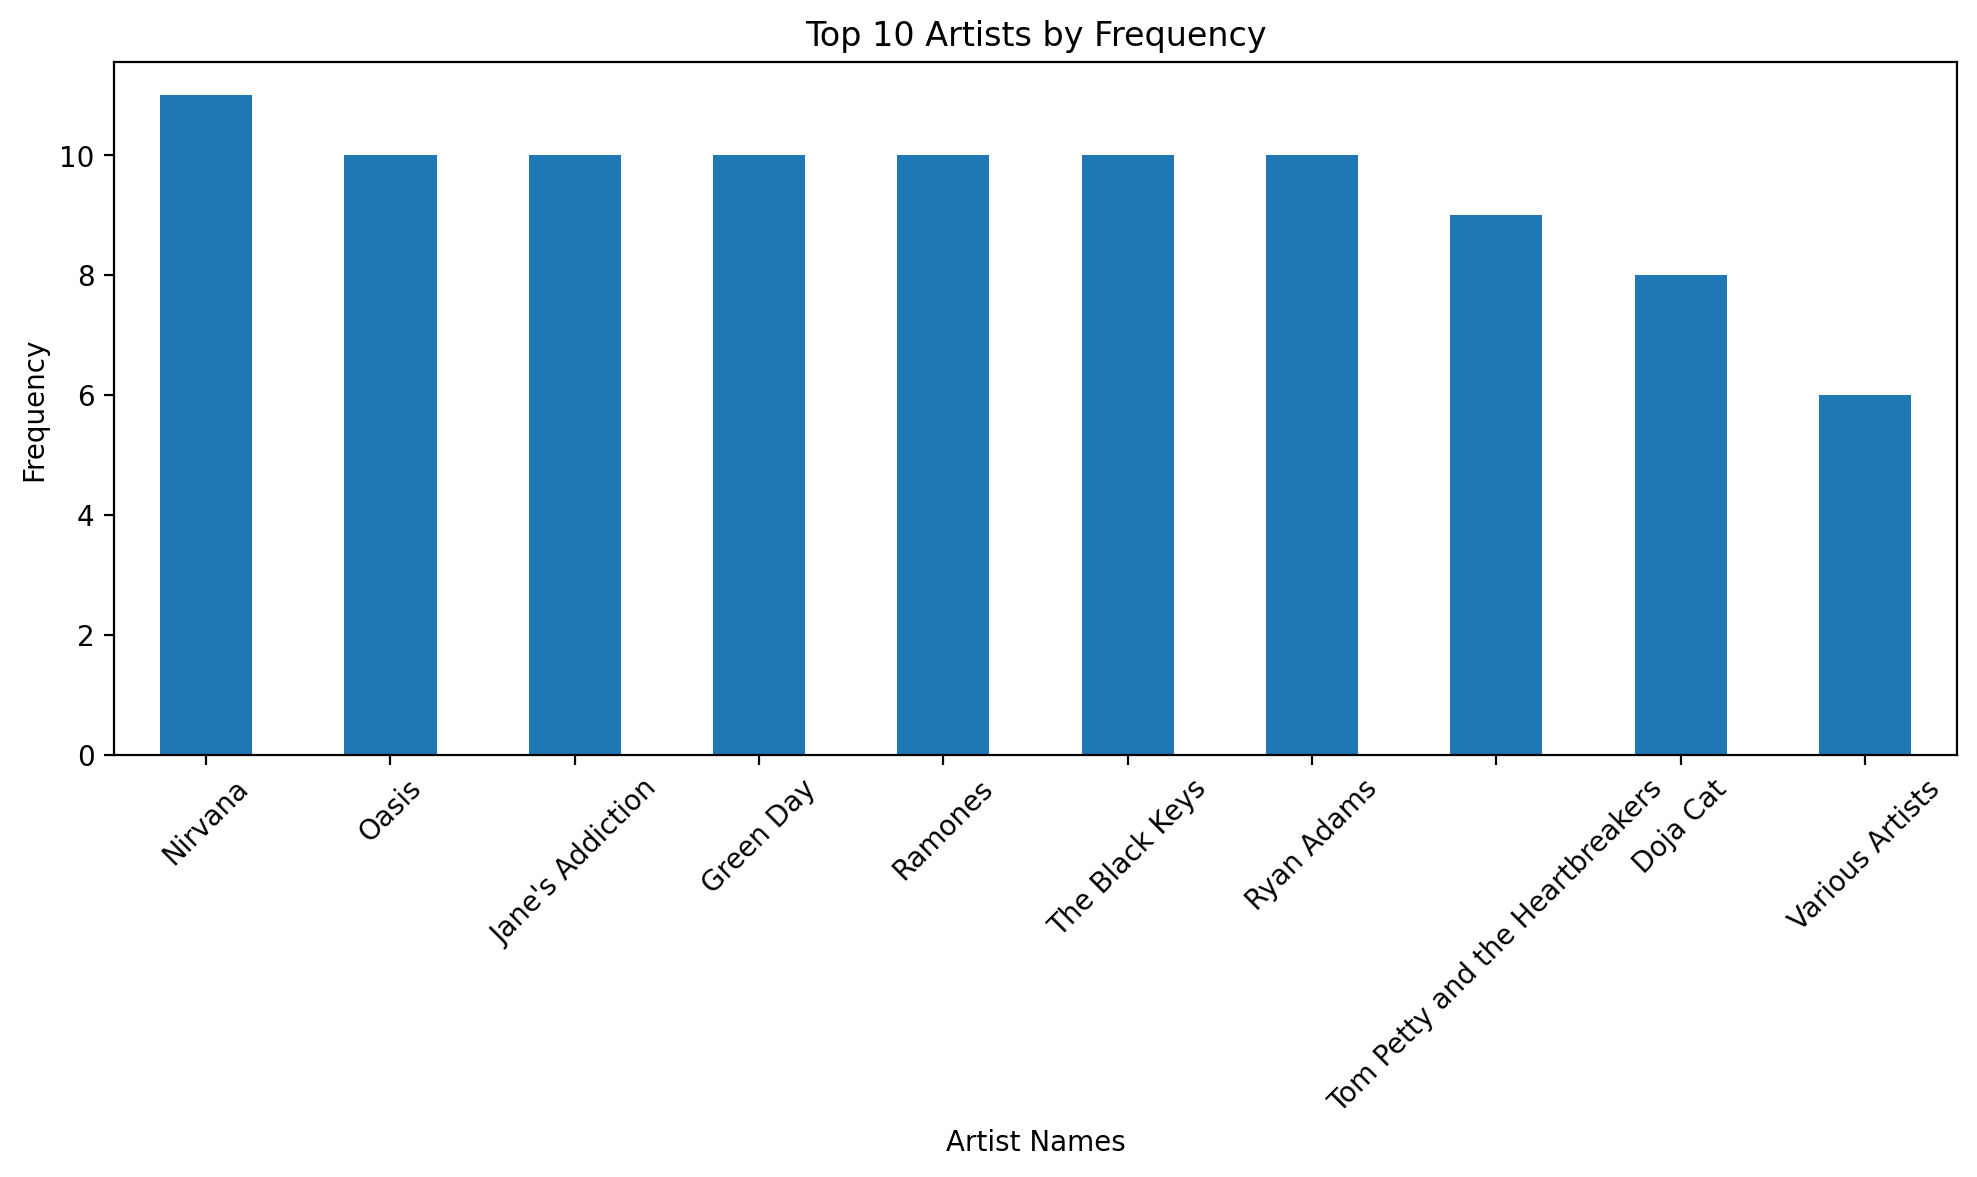

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded your data into a DataFrame called 'df'

# Get the top 10 artists based on their frequency
top_10_artists = df['artist'].value_counts().head(10)

# Create a bar plot
plt.figure(figsize=(10, 6))
top_10_artists.plot(kind='bar')
plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees
plt.xlabel('Artist Names')
plt.ylabel('Frequency')
plt.title('Top 10 Artists by Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Getting top 50 tracks from user
results = sp.current_user_top_tracks(limit=1000, offset=0,time_range='short_term')
results_1 = sp.current_user_top_tracks(limit=1000, offset=0,time_range='medium_term')
results_2 = sp.current_user_top_tracks(limit=1000, offset=0,time_range='long_term')

#https://github.com/lognorman20/spotify_recommender/blob/main/data_engineering.ipynb

In [ ]:
def create_track_dataframe(results):
    track_name = []
    track_id = []
    artist = []
    album = []
    duration = []
    popularity = []
    
    for i, items in enumerate(results['items']):
        track_name.append(items['name'])
        track_id.append(items['id'])
        artist.append(items["artists"][0]["name"])
        duration.append(items["duration_ms"])
        album.append(items["album"]["name"])
        popularity.append(items["popularity"])

    df_favourite = pd.DataFrame({
        "track_name": track_name,
        "album": album,
        "track_id": track_id,
        "artist": artist,
        "duration": duration,
        "popularity": popularity
    })

    return df_favourite

# Example usage:
# Assuming you have your 'results' dictionary
# df = create_track_dataframe(results)
# df.head()


In [ ]:
short_term = create_track_dataframe(results)

In [ ]:
medium_term=create_track_dataframe(results_1)

In [ ]:
long_term = create_track_dataframe(results_2)

In [102]:
long_term.head()

,track_name,album,track_id,artist,duration,popularity
0,Bad Boy (with Young Thug),Bad Boy (with Young Thug),43CIWpJaJHRcI4mUSjqgc2,Juice WRLD,157355,68
1,4U,4U,0G2OvqpvifsIHALlLqB5NG,Pi’erre Bourne,218000,42
2,Minute,Perfect Timing,3JWh19WsndEFg0UFRFeTiU,NAV,265373,62
3,Guillotine,The Life Of Pi'erre 4,7491l7CnemDkYH0jsoLvYr,Pi’erre Bourne,179890,53
4,Off The Map,After Me,6GNG0YQixWuLE0M5FtrRxY,SoFaygo,141582,57


In [ ]:
%%time
# Getting track features for each song in favorite song dataframe
fav_tracks = []
for track in short_term['track_id']:
    try:  
        track = getTrackFeatures(track)
        fav_tracks.append(track)
    except:
        pass

CPU times: total: 156 ms
Wall time: 13.6 s


In [ ]:
# Create favorite track wtih audio features dataset
df_fav = pd.DataFrame(fav_tracks, columns = ['track_id', 'name', 'album', 'artist', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'])
df_fav.head()

,track_id,name,album,artist,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,5rfMpJorQrwpvCOfDM7Q5L,Wake Up,Wake Up,Dom Corleo,2023-03-31,112153,60,0.752,0.024200,0.411,0.00000,0.1680,-8.407,0.0965,137.037,4
1,6Yj7Zhxt73uvwFFvzQXdxO,Flight's Booked,"Honestly, Nevermind",Drake,2022-06-17,254407,67,0.593,0.886000,0.410,0.09930,0.1150,-13.097,0.0531,122.584,4
2,05grSYrVwYw58YMOdJceyz,Patience (feat. Don Toliver),Pink Tape,Lil Uzi Vert,2023-06-30,262429,69,0.706,0.086000,0.640,0.00000,0.5370,-3.146,0.2030,143.905,4
3,3N3d4OWbPVxTQVBFqNyykk,Down Hill,"Honestly, Nevermind",Drake,2022-06-17,250864,57,0.718,0.965000,0.319,0.00036,0.0895,-11.261,0.0435,109.994,4
4,4FIgHqXd4KkOwxrGeLDYM2,Texts Go Green,"Honestly, Nevermind",Drake,2022-06-17,308820,65,0.765,0.000916,0.627,0.19500,0.0847,-4.607,0.0622,118.997,4


In [ ]:
len(df_fav)

50

In [108]:
# Dropping columns that could lead to data leakage
df_test= df_fav.drop(columns=['track_id','name', 'album', 'artist', 'release_date'])
df_test.head()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   length            50 non-null     int64  
 1   popularity        50 non-null     int64  
 2   danceability      50 non-null     float64
 3   acousticness      50 non-null     float64
 4   energy            50 non-null     float64
 5   instrumentalness  50 non-null     float64
 6   liveness          50 non-null     float64
 7   loudness          50 non-null     float64
 8   speechiness       50 non-null     float64
 9   tempo             50 non-null     float64
 10  time_signature    50 non-null     int64  
dtypes: float64(8), int64(3)
memory usage: 4.4 KB


In [109]:
import pandas as pd
import numpy as np

rs = np.random.RandomState(0)

corr = df_test.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
length,1.000000,0.347129,-0.005961,-0.212328,0.211099,-0.288809,0.153807,0.210387,-0.143633,-0.151467,0.047752
popularity,0.347129,1.000000,-0.112663,-0.018779,-0.082594,-0.065961,0.075887,-0.097790,-0.200731,-0.219219,-0.073781
danceability,-0.005961,-0.112663,1.000000,-0.279583,0.106627,-0.489393,-0.169411,0.307114,0.481086,0.050778,0.475552
acousticness,-0.212328,-0.018779,-0.279583,1.000000,-0.600884,0.397207,-0.134384,-0.576565,-0.061465,-0.119737,-0.259604
energy,0.211099,-0.082594,0.106627,-0.600884,1.000000,-0.540002,0.099168,0.750034,0.013278,0.184833,0.297237
instrumentalness,-0.288809,-0.065961,-0.489393,0.397207,-0.540002,1.000000,-0.099885,-0.707812,-0.283828,-0.158346,-0.607798
liveness,0.153807,0.075887,-0.169411,-0.134384,0.099168,-0.099885,1.000000,0.160585,0.116387,-0.162920,0.041410
loudness,0.210387,-0.097790,0.307114,-0.576565,0.750034,-0.707812,0.160585,1.000000,0.171953,0.119375,0.517926
speechiness,-0.143633,-0.200731,0.481086,-0.061465,0.013278,-0.283828,0.116387,0.171953,1.000000,0.281389,0.228981
tempo,-0.151467,-0.219219,0.050778,-0.119737,0.184833,-0.158346,-0.162920,0.119375,0.281389,1.000000,0.023966


In [112]:
# Dropping columns that could lead to data leakage
df_test1= df.drop(columns=['track_id','name', 'album', 'artist', 'release_date'])

rs = np.random.RandomState(0)
corr = df_test1.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps


,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
length,1.000000,0.077917,-0.170478,-0.074195,0.118925,-0.141027,0.071003,0.088331,0.052697,-0.096957,0.017550
popularity,0.077917,1.000000,0.036750,-0.128738,0.083719,-0.024443,-0.171696,0.157021,-0.361425,0.022008,-0.011013
danceability,-0.170478,0.036750,1.000000,-0.083939,-0.109130,-0.201568,-0.067622,0.075409,0.272304,-0.153637,0.062528
acousticness,-0.074195,-0.128738,-0.083939,1.000000,-0.654708,0.286825,-0.093907,-0.621650,0.116958,-0.141679,-0.208206
energy,0.118925,0.083719,-0.109130,-0.654708,1.000000,-0.318569,0.212847,0.781015,-0.094544,0.194530,0.158737
instrumentalness,-0.141027,-0.024443,-0.201568,0.286825,-0.318569,1.000000,-0.054530,-0.515495,-0.141754,-0.073680,-0.033741
liveness,0.071003,-0.171696,-0.067622,-0.093907,0.212847,-0.054530,1.000000,0.100723,0.147569,0.073156,0.024859
loudness,0.088331,0.157021,0.075409,-0.621650,0.781015,-0.515495,0.100723,1.000000,-0.137432,0.143907,0.102606
speechiness,0.052697,-0.361425,0.272304,0.116958,-0.094544,-0.141754,0.147569,-0.137432,1.000000,-0.063789,0.032752
tempo,-0.096957,0.022008,-0.153637,-0.141679,0.194530,-0.073680,0.073156,0.143907,-0.063789,1.000000,0.002781


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


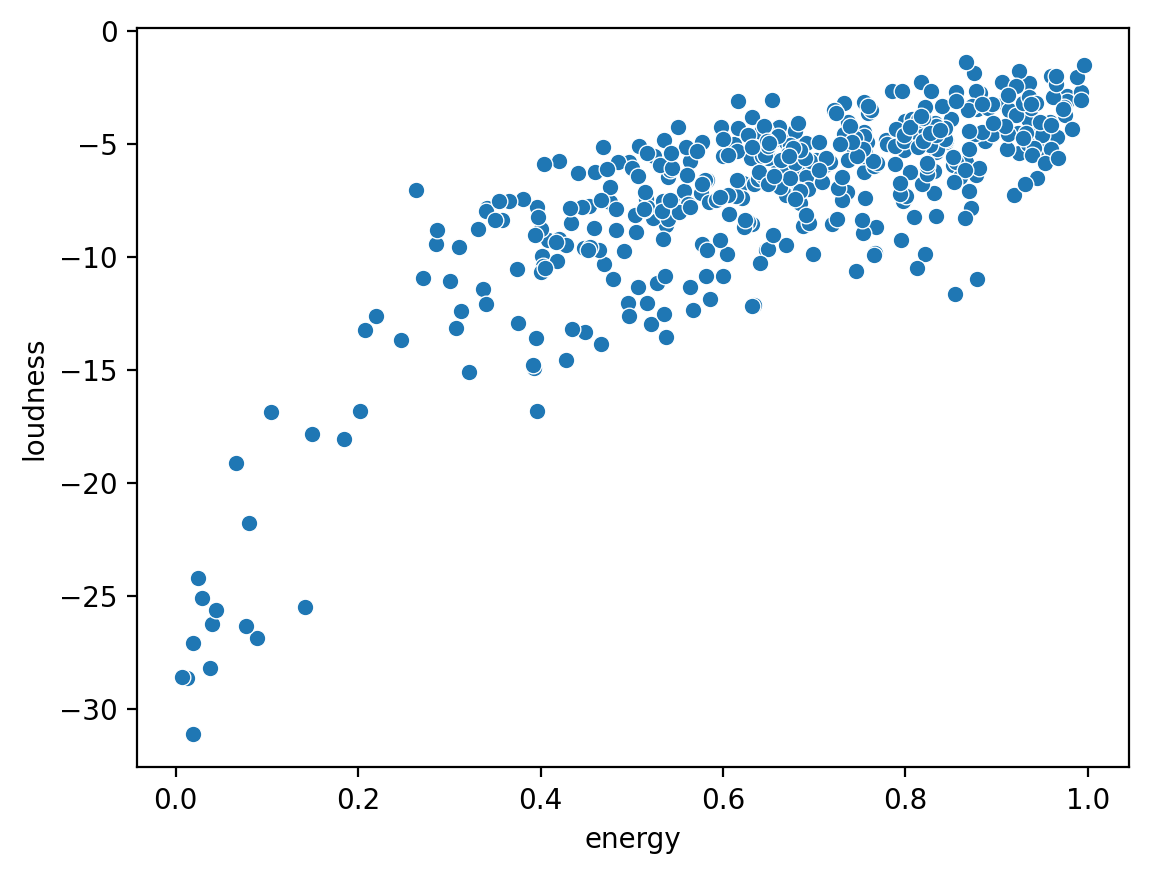

In [115]:
sns.scatterplot(x='energy', y='loudness', data=df_test1)
plt.show()

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instea

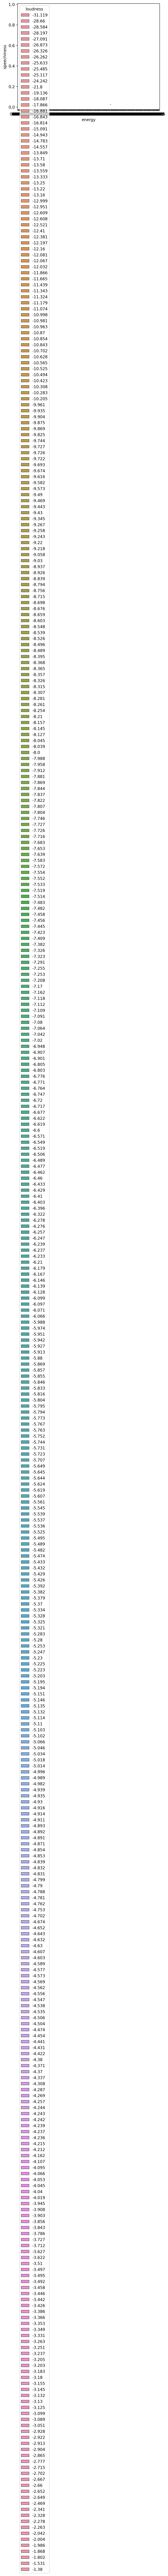

In [123]:
sns.violinplot(x='energy', y='speechiness', hue='loudness', data=df_test1)
plt.show()

In [124]:
df['year'] =data['decade'] +(data['decade'] %10 )

,track_id,name,album,artist,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,2IGMVunIBsBLtEQyoI1Mu7,Paint The Town Red,Paint The Town Red,Doja Cat,2023-08-04,231750,100,0.868,0.269000,0.538,0.000003,0.0901,-8.603,0.1740,99.968,4
1,1BxfuPKGuaTgP7aM0Bbdwr,Cruel Summer,Lover,Taylor Swift,2019-08-23,178426,98,0.552,0.117000,0.702,0.000021,0.1050,-5.707,0.1570,169.994,4
2,4KULAymBBJcPRpk1yO4dOG,I Remember Everything (feat. Kacey Musgraves),Zach Bryan,Zach Bryan,2023-08-25,227195,91,0.429,0.554000,0.453,0.000002,0.1020,-7.746,0.0459,77.639,4
3,3IX0yuEVvDbnqUwMBB3ouC,bad idea right?,GUTS,Olivia Rodrigo,2023-09-08,184783,92,0.627,0.001930,0.879,0.000007,0.0647,-3.446,0.0955,129.979,4
4,5mjYQaktjmjcMKcUIcqz4s,Strangers,Strangers,Kenya Grace,2023-09-01,172964,92,0.628,0.701000,0.523,0.002740,0.2190,-8.307,0.0946,169.982,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2tBxJ43XiwEzhf7Xalc5UG,Songbird,Heathen Chemistry,Oasis,2002-07-01,127600,61,0.491,0.274000,0.561,0.000002,0.2300,-6.396,0.0279,134.881,4
496,3MCuDi4gQrf7Xms8lTpTAx,Don't Go Away,Be Here Now,Oasis,1997-08-21,288600,58,0.426,0.053200,0.838,0.000003,0.0829,-4.380,0.0362,81.089,4
497,4jJfa4mO5JjV9Tz2aAxE2M,Supersonic - Remastered,Definitely Maybe (Deluxe Edition Remastered),Oasis,1994,283786,63,0.359,0.000063,0.913,0.012100,0.0954,-2.865,0.0391,104.058,4
498,2A7GGXmTlXuH9LOvBXgOX4,Champagne Supernova - Remastered,(What's The Story) Morning Glory? (Deluxe Rema...,Oasis,1995,451320,68,0.293,0.458000,0.817,0.050900,0.3550,-3.786,0.0390,150.249,4
